In [2]:
import pandas as pd
import numpy as np

import featuretools as ft
from featuretools.selection import (
    remove_highly_correlated_features,
    remove_highly_null_features,
    remove_single_value_features,
)

from datetime import datetime
from uuid import uuid4
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
import xgboost as xgb

from scipy.stats import uniform, randint


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from typing import List, Any

In [3]:
# https://github.com/IBM/telco-customer-churn-on-icp4d
URL_TO_DATA = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"


BACK_COUNT_DATE = datetime.fromisoformat("2022-01-01")
TEST_SIZE = 0.2
VALID_SIZE = 0.25
RANDOM_STATE = 42
NUMERIC_TRANSFORMER_REPLACEMENT = "median"

In [21]:
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy=NUMERIC_TRANSFORMER_REPLACEMENT)),
        ("scaler", StandardScaler()),
    ]
)

- ft titanic https://www.kaggle.com/code/liananapalkova/automated-feature-engineering-for-titanic-dataset/notebook
- the dataset https://github.com/IBM/telco-customer-churn-on-icp4d/blob/master/data/Telco-Customer-Churn.csv
- titanic https://medium.com/dataexplorations/tool-review-can-featuretools-simplify-the-process-of-feature-engineering-5d165100b0c3
- time indexing recomandations https://stackoverflow.com/questions/49711987/how-do-i-prevent-data-leakage-with-featuretools




### Denormalize into 
- customer_df:      customer_id (PK), subscription_id (FK), gender, SeniorCitizen, Partner, Dependents, tenure, Churn
- services_df:      service_id (PK), service_name
- subscription_df:  subscription_id (PK), service_id, customer_id
- billing_df:       billing_id, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges


In [5]:
# in case of CERTIFICATE_VERIFY_FAILED run Install Certificates.command
# see also https://stackoverflow.com/questions/50236117/scraping-ssl-certificate-verify-failed-error-for-http-en-wikipedia-org
df = pd.read_csv(filepath_or_buffer=URL_TO_DATA, index_col=0)

In [6]:
# convert
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# generate syntatic time index
df["ContractStartDate"] = list(
    map(
        lambda tenure, dat=BACK_COUNT_DATE: dat - relativedelta(months=-tenure),
        df["tenure"],
    )
)
# df["customerID"] = df.index
df["billingId"] = [str(uuid4()) for _ in range(df.shape[0])]
df["subscriptionId"] = [str(uuid4()) for _ in range(df.shape[0])]

# convert to 1/0
df["Churn"] = np.where(df["Churn"] == "Yes", 1, 0)

In [7]:
y = df["Churn"]
X = df.drop(columns=["Churn"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=VALID_SIZE, random_state=RANDOM_STATE
)  # 0.25 x 0.8 = 0.2

In [8]:
es = ft.EntitySet(id="customer_churn")

es.add_dataframe(
    dataframe_name="customers",
    index="customerID",
    time_index="ContractStartDate",
    dataframe=X_train,
)

es.normalize_dataframe(
    base_dataframe_name="customers",
    new_dataframe_name="subscriptions",
    index="subscriptionId",
)

es.normalize_dataframe(
    base_dataframe_name="customers", new_dataframe_name="billings", index="billingId"
)

/Users/tara/Library/Caches/pypoetry/virtualenvs/data-science-playbooks-BCpveUor-py3.10/lib/python3.10/site-packages/featuretools/entityset/entityset.py:1906: UserWarning: index customerID not found in dataframe, creating new integer column
  warnings.warn(


Entityset: customer_churn
  DataFrames:
    customers [Rows: 4225, Columns: 23]
    subscriptions [Rows: 4225, Columns: 2]
    billings [Rows: 4225, Columns: 2]
  Relationships:
    customers.subscriptionId -> subscriptions.subscriptionId
    customers.billingId -> billings.billingId

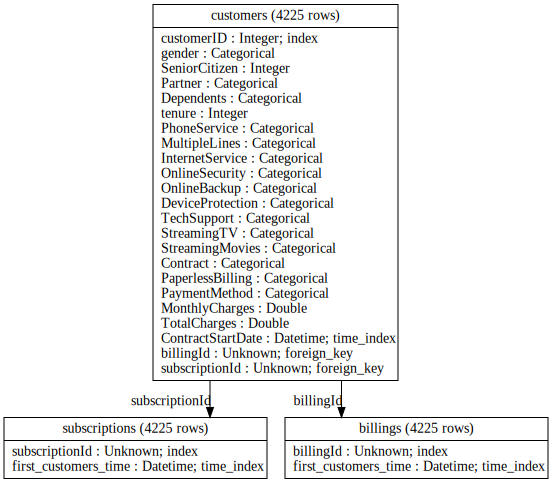

In [9]:
es.plot()

In [10]:
feature_matrix, feature_defs = ft.dfs(
    entityset=es, target_dataframe_name="customers", max_depth=2
)

In [11]:
feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_defs)
feature_matrix_enc.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'subscriptions.COUNT(customers)',
       'subscriptions.MAX(customers.MonthlyCharges)',
       'subscriptions.MAX(customers.SeniorCitizen)',
       'subscriptions.MAX(customers.TotalCharges)',
       'subscriptions.MAX(customers.tenure)',
       'subscriptions.MEAN(customers.MonthlyCharges)',
       ...
       'billings.MONTH(first_customers_time) is unknown',
       'billings.WEEKDAY(first_customers_time) = 1',
       'billings.WEEKDAY(first_customers_time) = 4',
       'billings.WEEKDAY(first_customers_time) = 6',
       'billings.WEEKDAY(first_customers_time) = 0',
       'billings.WEEKDAY(first_customers_time) = 2',
       'billings.WEEKDAY(first_customers_time) = 5',
       'billings.WEEKDAY(first_customers_time) is unknown',
       'billings.YEAR(first_customers_time) = 2022',
       'billings.YEAR(first_customers_time) is unknown'],
      dtype='object', length=312)

In [12]:
all_features = feature_matrix_enc.columns.to_list()

In [13]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy=NUMERIC_TRANSFORMER_REPLACEMENT)),
        ("scaler", StandardScaler()),
    ]
)

feature_selector = Pipeline(
    steps=[
        (
            "rm_highly_correlated_features",
            FunctionTransformer(remove_highly_correlated_features),
        ),
        (
            "rm_highly_null_features",
            FunctionTransformer(remove_highly_null_features),
        ),
        (
            "rm_single_value_features",
            FunctionTransformer(remove_single_value_features),
        ),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("feature_selector", feature_selector, all_features),
    ]
)
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['tenure', 'MonthlyCharges', 'TotalCharges']),
                                ('feature_selector',
                                 Pipeline(steps=[('rm_highly_correlated_features',
                                                  FunctionTransformer(func=<function remove_highly_correlated_features at 0x13886a320>)),
                                                 ('rm_highly_null_featur...
                                  'subscriptions.NUM_UNIQUE(customers.OnlineSecurity)',
                                  'subscriptions.NUM_UNIQUE(customers.PaperlessBilling)',
                                  'subscriptions.NUM_UNIQUE(customers.Partner)',
                                  'subscriptions.NUM_UNIQUE(customers.PaymentMethod)',
                                  'subscriptions.NUM_UNIQUE(customers.PhoneService)',
                                  'subscriptions.NUM_UNIQUE(customers.StreamingMovies)',
                                  'subscriptions.NUM_UNIQUE(customers.StreamingTV)', ...])])

In [23]:
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)]
)

clf = Pipeline(
    # steps=[("preprocessor", preprocessor), ("classifier", xgb.XGBClassifier(objective="binary:logistic", random_state=RANDOM_STATE))]
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

clf.fit(feature_matrix_enc, y_train)
print("model score: %.3f" % clf.score(X_val, y_val))
print("model score: %.3f" % clf.score(X_test, y_test))

ValueError: Found input variables with inconsistent numbers of samples: [936, 4225]

## Estimating baseline Model

In [ ]:
categorical_features = [
    "gender",
    "SeniorCitizen",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]

In [ ]:
one_hot_enc = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("onehot", one_hot_enc, categorical_features),
    ]
)
preprocessor

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = Pipeline(
    # steps=[("preprocessor", preprocessor), ("classifier", xgb.XGBClassifier(objective="binary:logistic", random_state=RANDOM_STATE))]
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_val, y_val))
print("model score: %.3f" % clf.score(X_test, y_test))

In [29]:
#feature_matrix_enc.shape
y_train.shape
#X_train.shape
feature_matrix.shape

(936, 141)